# List of planets with mass and distance, Center of Mass for each system
### 1. read the file from exoplanet.eu
List of planets from exoplanet.eu, it is taking mass (and its uncertaintly), semi_major (and its uncertaintly), Metallicity (and its uncertaintly).  

In [105]:
import pandas as pd 
import numpy as np

data_ep = pd.read_csv('data/exoplanet.eu_catalog.csv', 
                      usecols=['mass','mass_error_min','semi_major_axis',
                               'semi_major_axis_error_min','star_name',
                               'star_metallicity','star_metallicity_error_min'])
#data_ep
#data_ep.count()

**Remember**: `pd.notnull("name_of_column")` deletes the NaN values in the column. 

**Remember**: `data=data[['column_a','column_b',..,'column_n',]]` to get a new order in the DataFrame

Now is necessary processing the data with the prurpose to obtain the Center of Mass CM, `data1` is a DataFrame without the NaN values of _mass_ and _semi major axis_. Finally, we get 1667 rows.

In [106]:
dataA = data_ep.dropna(subset=['mass', 
                               'semi_major_axis'])
data1 = dataA[['star_name','mass','semi_major_axis']]
#--------------------------------------------------------------
dataB = data_ep.dropna(subset=['mass','mass_error_min',
                               'semi_major_axis',
                               'semi_major_axis_error_min'])
data2 = dataB[['star_name','mass', 'mass_error_min',
               'semi_major_axis','semi_major_axis_error_min']]
#--------------------------------------------------------------
#data2
#print(len(data2),len(data1))
#(np.isnan(data2.semi_major_axis_error_min)).sum()

So, `data2` is a DataFrame without the NaN values of mass, semi major axis and their uncertainties. Finally, we get 1220 rows, 447 rows less than `data1`. 

For the semi major axes column, withouth NaN values we have `data3`, it is usefull for planetary systems with one planet observed.

In [107]:
data3 = data_ep[pd.notnull(data_ep["semi_major_axis"])]
data3 = data3[pd.notnull(data3["star_name"])]
data3 = data3[['star_name',"semi_major_axis"]]
#data3
#data3.groupby("star_name").count()

### 2. Center of Mass 
We need to estimate the CM for each planet, so:
\begin{equation*}
\text{CM} = \frac{\sum\limits_{k=1}^n(m_{k}\vec{r_{k}})}{\sum \limits_{k=1}^{n}m_{k}} %=\frac{\sum\limits_{k=1}^n(m_{k}\vec{r_{k}})}{M_{T}}
\end{equation*}
For do it, is nessesary get the values CM for each planet, so with the columns of `mass` and distance from the star  `semi_major_axis` we can get $\boxed{m_{k}\vec{r_{k}}}$ values.

**Remember:** The `data.groupby("key")` split the data in groups which are the key.

**Remember:** The `data[i].multiply(data[j])` multiplies the comun i and j of DataFrame or Series i and j, row by row.

**Remember:** The `data.groupby.groups.keys()` get the keys of the split data.

#### Employing  `data1`: #### 

In [108]:
data1
r_i = data1["semi_major_axis"]
m_i = data1["mass"]
#----------------------------------------------------------------------
#the multiplications between columns, new column CM_i:
data1 = data1.assign(CM_i=r_i.multiply(m_i))  
#----------------------------------------------------------------------
#value, for each planet in the system. 
p_system = data1.groupby("star_name")
#----------------------------------------------------------------------
#A = list(p_system.groups.keys())
#A
#p_system.count()
#(np.isnan(data1.CM_i)).sum()

However, the calculus of the CM, counting the planetary systems with the same satar. 

### 3. Gaussian Mixture Model
#### Center of Mass
#### Employing  `data1`: #### 
The Gaussian Mixture model: 

In [109]:
#The total mass, for each system: 
M_total = p_system["mass"].sum()#.tolist() changes from Series to list
#----------------------------------------------------------------------
#The sum of the CM_i for each system:
sum_rm = p_system['CM_i'].sum()#.tolist()
#----------------------------------------------------------------------
#total center of mass, for each extraplanetary system
CM = sum_rm.divide(M_total)
#----------------------------------------------------------------------
system = list(p_system.groups.keys())
#system
#----------------------------------------------------------------------
#the data after get the Center of Mass for each system 
data1 = pd.DataFrame({'system_name':system,
                      'total_mass':M_total.tolist(),
                      'center_of_Mass':CM.tolist()})
#len(data1) 
#(np.isnan(data1.center_of_Mass)).sum()

(-0.1, 0.1)

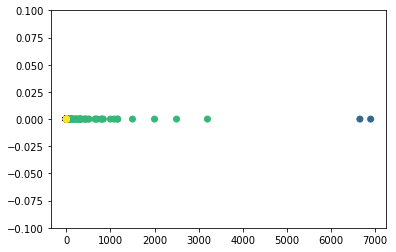

In [110]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
%matplotlib inline

#GaussianMixture: 
#number of parametres, 
#each parameter has its own covariance type

gmm = GaussianMixture(4, covariance_type='full', random_state=0)
CM=data1[["center_of_Mass"]]
gmm.fit(CM.values)
cluster_label = gmm.predict(CM.values)
#CM.values[:]
plt.scatter((CM.values),np.zeros(len(CM)), c=cluster_label);
plt.ylim(-0.1,0.1)


The Bayesian information criterion

In [111]:
#Bayesian information criterion 
bic=[]
for i in range(10):
    i+=1
    gmm = GaussianMixture(i, covariance_type='full', random_state=0)
    CM_log=np.log10(data1[["center_of_Mass"]])
    gmm.fit(CM_log.values)
    bic+=[gmm.bic(CM_log.values)]
#bic

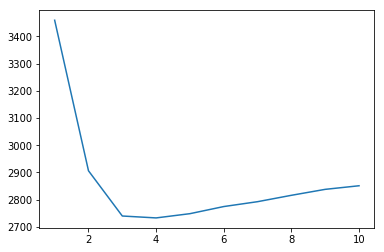

In [112]:
plt.plot(range(1,11),bic)

(-0.1, 1)

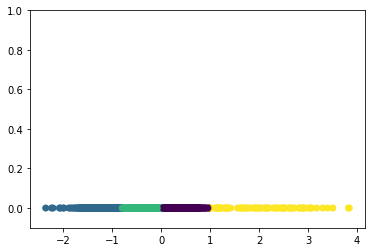

In [113]:
gmm = GaussianMixture(4, covariance_type='full', random_state=0)
CM_log=np.log10(data1[["center_of_Mass"]])
gmm.fit(CM_log.values)
cluster_label = gmm.predict(CM_log.values)
#CM_log.values[:, 0]
plt.scatter((CM_log.values),np.zeros(len(CM_log)),c=cluster_label);
plt.ylim(-0.1,1)

In [114]:
gmm.means_

array([[ 0.34963506],
       [-1.30543662],
       [-0.1755601 ],
       [ 1.99563537]])

In [115]:
#Normal distribution 
from scipy.stats import norm

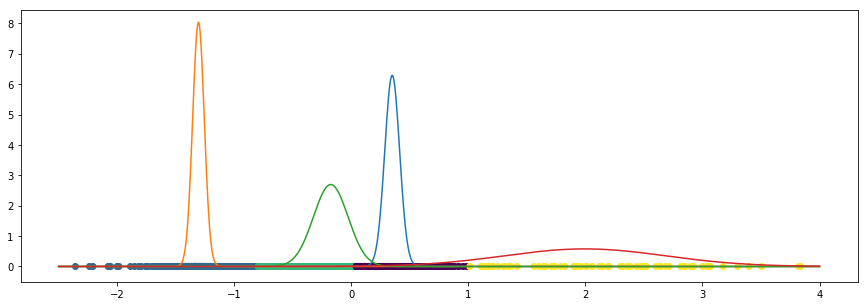

In [116]:
plt.figure(figsize=(15,5))
sma=np.linspace(-2.5,4,1000)
for m,s in zip(gmm.means_,gmm.covariances_):
    plt.plot(sma, norm.pdf(sma,m,s)[0])
plt.scatter((CM_log.values),np.zeros(len(CM_log)),c=cluster_label);

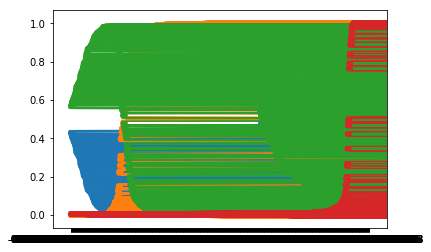

In [117]:
for i in range(4):
    plt.scatter(CM_log,gmm.predict_proba(CM_log)[:,i]);
#plt.show()

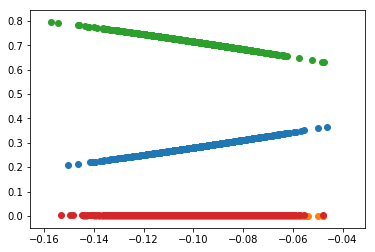

In [118]:
for i in range(4):
    AA=np.log10(np.random.normal(0.8,0.03,1000))
    AA=AA[:,np.newaxis]
    plt.scatter(AA,gmm.predict_proba(AA)[:,i])

## ... Draws
Employing m and $\Delta$m, a and $\Delta$a, from `data2`.

In [162]:
p_system = data2.groupby("star_name")
system_list = list(p_system.groups.keys())
#system_list[10]

In [192]:
for i in range(len(system_list)):
    system_i = data2[data2.star_name == system_list[i]]
    draw_i=[]
    for j in  
        masses=np.random.normal(system_i.mass,
                        system_i.mass_error_min)

masses
#print(masses[100])
#print(data2.mass[0])
    

   star_name  mass  mass_error_min  semi_major_axis  semi_major_axis_error_min
10    24 Sex  1.99            0.38            1.333                      0.009
11    24 Sex  0.86            0.22            2.080                      0.020


array([1.68154684, 0.71458742])

In [181]:


#def CenterOfMass(rm_i,r):
#        self.rm_i = self.data["mass"].multiply(self.data["semi_major_axis"])
#        self.data_i = self.data.assign(CM_i = self.rm_i.values) 
#        p_system = self.data_i.groupby("star_name")
#        sum_rm = p_system['CM_i'].sum()#.tolist()
#        self.CM = sum_rm.divide(self.M_total) 

#print(len(data2.mass.values),len(data2.mass_error_min))

#data2
#mass_i = np.random.normal(data2.mass.values[0],
#                          data2.mass_error_min[0],1000)
#print(data2.mass.values[0],data2.mass_error_min[0])
#plt.hist(mass_i,15)
#semiM_axis_i = np.random.normal(data2.semi_major_axis.values,
#                                data2.semi_major_axis_error_min, 
#                                10000)
#COM_i=[]
#mass_i
#for i in range(len(mass_i)):
#    com = (mass_i[i]*semiM_axis_i[i]).sum()/mass_i[i].sum()
#    COM_i.append(com)
#len(COM_i)
#len(data2.star_name) == len(COM_i)
#plt.hist(COM_i,15)
#plt.hist(semiM_axis_i,10)

#### Metallicity

In [196]:
dataMet = data_ep[pd.notnull(data_ep["star_metallicity"])]
dataMetA = dataMet[pd.notnull(dataMet["star_metallicity_error_min"])]
dataMet = dataMetA[['star_name',"star_metallicity","star_metallicity_error_min"]]

In [195]:
gmm2 = GaussianMixture(3, covariance_type='full', random_state=0)
B=dataMet[["star_metallicity"]]
gmm2.fit(B.values)
cluster_label = gmm2.predict(B.values)
B.values[:, 0]
plt.scatter((B.values),np.zeros(len(B)), c=cluster_label);
plt.ylim(-0.1,1)

NameError: name 'dataMet' is not defined

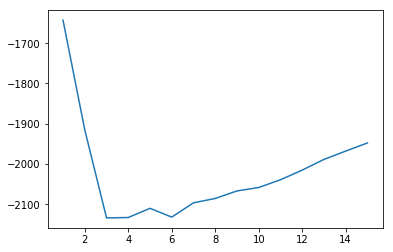

In [19]:
bic=[]
for i in range(15):
    i+=1
    gmm2 = GaussianMixture(i, covariance_type='full', random_state=0)
    A=data1[["center_of_Mass"]]
    gmm2.fit(B.values)
    bic+=[gmm2.bic(B.values)]
plt.plot(range(1,16),bic)

ValueError: 'c' argument has 2524 elements, which is not acceptable for use with 'x' with size 1205, 'y' with size 1205.

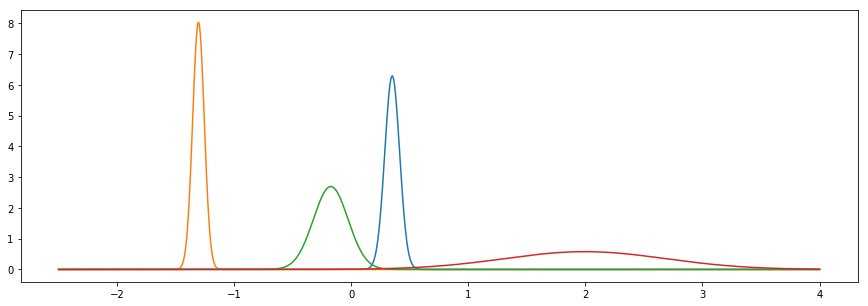

In [20]:
plt.figure(figsize=(15,5))
sma=np.linspace(-2.5,4,1000)
for m,s in zip(gmm.means_,gmm.covariances_):
    plt.plot(sma, norm.pdf(sma,m,s)[0])
plt.scatter((A.values),np.zeros(len(A)), c=cluster_label);